# Import from Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Install Catboost

In [2]:
pip install lightgbm catboost scikit-learn joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.1 MB/s eta 0:00:00


# Updated Code for 100% Dataset Training (Final Working)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


Dataset Shape: (1200000, 16)
First few rows of the dataset:
            A          B           C          D           E          F  \
0  231.420023 -12.210984  217.624839 -15.611916  140.047185  76.904999   
1  -38.019270 -14.195695    9.583547  22.293822  -25.578283 -18.373955   
2  -39.197085 -20.418850   21.023083  19.790280  -25.902587 -19.189004   
3  221.630408  -5.785352  216.725322  -9.900781  126.795177  85.122288   
4  228.558412 -12.447710  204.637218 -13.277704  138.930529  91.101870   

            G           H          I           J           K         L  \
0  131.591871  198.160805  82.873279  127.350084  224.592926 -5.992983   
1   -0.094457  -33.711852  -8.356041   23.792402    4.199023  2.809159   
2   -2.953836  -25.299219  -6.612401   26.285392    5.911292  6.191587   
3  108.857593  197.640135  82.560019  157.105143  212.989231 -3.621070   
4  115.598954  209.300011  89.961688  130.299732  201.795100 -1.573922   

           M           N           O  Class  
0 -1

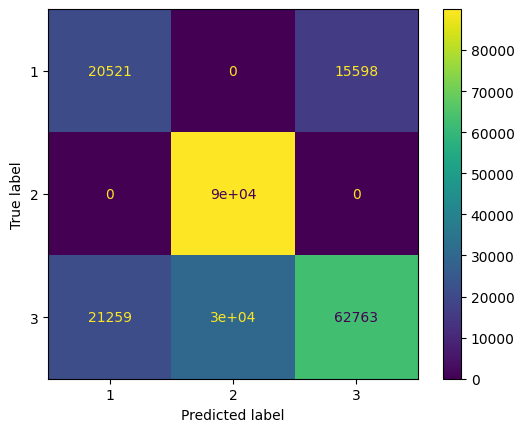

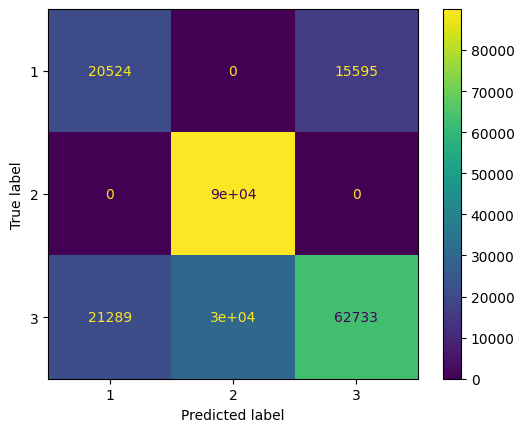

In [3]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import joblib

# Load the dataset
file_path = '/content/drive/MyDrive/data/data_public.csv'  # Update with your file path
df = pd.read_csv(file_path)

# Display dataset info
print("Dataset Shape:", df.shape)
print("First few rows of the dataset:")
print(df.head())

# Separate features and target variable
X = df.drop(columns=["Class"])
y = df["Class"]

# Map the labels to start from 0
label_mapping = {label: idx for idx, label in enumerate(sorted(y.unique()))}
y = y.map(label_mapping)

# Split into Train-Test with 20% test size
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print(f"Training Size: {len(X_train)} rows, Testing Size: {len(X_test)} rows")

# Preprocessing: Standardizing the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply Partial SMOTE to oversample Classes 1 and 3
print("Applying Partial SMOTE...")
smote = SMOTE(sampling_strategy={0: 300000, 1: 500000, 2: 600000}, random_state=42)  # Adjusted oversampling
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Check new class distribution
class_counts = pd.Series(y_train_balanced).value_counts()
print("Class distribution after Partial SMOTE:", class_counts.to_dict())

# Compute class weights to handle remaining imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_balanced), y=y_train_balanced)
class_weights_map = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weights_map)

# ------------------------------------------------------------
# Train LightGBM with the current best parameters
print("Training LightGBM Model with current setup...")

lgbm_best_params = {
    'num_leaves': 31,
    'max_depth': 8,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_samples': 20,
    'objective': 'multiclass',
    'num_class': len(label_mapping),
    'class_weight': class_weights_map,
    'random_state': 42
}

lgbm_model = LGBMClassifier(**lgbm_best_params)
lgbm_model.fit(X_train_balanced, y_train_balanced)

# Predict and evaluate LightGBM
lgbm_y_pred = lgbm_model.predict(X_test_scaled)
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
lgbm_y_pred_original = pd.Series(lgbm_y_pred).map(reverse_label_mapping)
y_test_original = y_test.map(reverse_label_mapping)

print("LightGBM Model Evaluation")
print("LightGBM Model Accuracy:", accuracy_score(y_test_original, lgbm_y_pred_original))
print("LightGBM Model Classification Report:")
print(classification_report(y_test_original, lgbm_y_pred_original))

cm = confusion_matrix(y_test_original, lgbm_y_pred_original)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=reverse_label_mapping.values())
disp.plot()
print("LightGBM Confusion matrix displayed.")

# Save the LightGBM model
joblib.dump(lgbm_model, 'lightgbm_model_100pct.pkl')
print("LightGBM model saved as 'lightgbm_model_100pct.pkl'")

# ------------------------------------------------------------
# Train CatBoost with default settings for comparison
print("Training CatBoost Model...")

catboost_model = CatBoostClassifier(
    iterations=300,
    depth=8,
    learning_rate=0.05,
    loss_function='MultiClass',
    class_weights=list(class_weights_map.values()),
    random_state=42,
    verbose=50
)

catboost_model.fit(X_train_balanced, y_train_balanced)

# Predict and evaluate CatBoost
catboost_y_pred = catboost_model.predict(X_test_scaled)
catboost_y_pred_original = pd.Series(catboost_y_pred.flatten()).map(reverse_label_mapping)

print("CatBoost Model Evaluation")
print("CatBoost Model Accuracy:", accuracy_score(y_test_original, catboost_y_pred_original))
print("CatBoost Model Classification Report:")
print(classification_report(y_test_original, catboost_y_pred_original))

cm = confusion_matrix(y_test_original, catboost_y_pred_original)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=reverse_label_mapping.values())
disp.plot()
print("CatBoost Confusion matrix displayed.")

# Save the CatBoost model
catboost_model.save_model('catboost_model_100pct.cbm')
print("CatBoost model saved as 'catboost_model_100pct.cbm'")


## Updated Code for Fully Balanced Classes

In [4]:
# Import necessary libraries
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight

# Balancing all classes with SMOTE
from imblearn.over_sampling import SMOTE

print("Balancing all classes with SMOTE...")
# Use "auto" to automatically balance all classes equally
smote = SMOTE(sampling_strategy="auto", random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Check the new class distribution
class_counts = pd.Series(y_train_balanced).value_counts()
print("Class distribution after SMOTE:", class_counts.to_dict())


# Compute class weights (optional, since SMOTE balances the dataset)
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_balanced), y=y_train_balanced)
class_weights_map = {i: class_weights[i] for i in range(len(class_weights))}
print("Class Weights:", class_weights_map)

# ------------------------------------------------------------
# Train LightGBM with balanced classes
print("Training LightGBM Model with balanced classes...")

lgbm_params_balanced = {
    'num_leaves': 31,
    'max_depth': 8,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_samples': 20,
    'objective': 'multiclass',
    'num_class': len(label_mapping),
    'random_state': 42
}

lgbm_balanced_model = LGBMClassifier(**lgbm_params_balanced)
lgbm_balanced_model.fit(X_train_balanced, y_train_balanced)

# Evaluate LightGBM
lgbm_y_pred_balanced = lgbm_balanced_model.predict(X_test_scaled)
lgbm_y_pred_balanced_original = pd.Series(lgbm_y_pred_balanced).map(reverse_label_mapping)

print("LightGBM Model Evaluation with Balanced Classes")
print("Accuracy:", accuracy_score(y_test_original, lgbm_y_pred_balanced_original))
print("Classification Report:")
print(classification_report(y_test_original, lgbm_y_pred_balanced_original))

# Save LightGBM Model
joblib.dump(lgbm_balanced_model, 'lightgbm_balanced_model.pkl')

# ------------------------------------------------------------
# Train CatBoost with balanced classes
print("Training CatBoost Model with balanced classes...")

catboost_balanced_model = CatBoostClassifier(
    iterations=300,
    depth=8,
    learning_rate=0.05,
    loss_function='MultiClass',
    random_state=42,
    verbose=50
)

catboost_balanced_model.fit(X_train_balanced, y_train_balanced)

# Evaluate CatBoost
catboost_y_pred_balanced = catboost_balanced_model.predict(X_test_scaled)
catboost_y_pred_balanced_original = pd.Series(catboost_y_pred_balanced.flatten()).map(reverse_label_mapping)

print("CatBoost Model Evaluation with Balanced Classes")
print("Accuracy:", accuracy_score(y_test_original, catboost_y_pred_balanced_original))
print("Classification Report:")
print(classification_report(y_test_original, catboost_y_pred_balanced_original))

# Save CatBoost Model
catboost_balanced_model.save_model('catboost_balanced_model.cbm')


Balancing all classes with SMOTE...
Class distribution after SMOTE: {1: 455617, 2: 455617, 0: 455617}
Class Weights: {0: 1.0, 1: 1.0, 2: 1.0}
Training LightGBM Model with balanced classes...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.204553 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 1366851, number of used features: 15
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
LightGBM Model Evaluation with Balanced Classes
Accuracy: 0.6858583333333333
Classification Report:
              precision    recall  f1-score   support

           1       0.42      0.65      0.51     36119
           2       0.75      1.00      0.86     89977
           3       0.80      0.45      0.58    113904

    accuracy                          

## Updated Code with Partial SMOTE

Applying Partial SMOTE for Balancing...
Class distribution after Partial SMOTE: {2: 455617, 1: 450000, 0: 300000}
Class Weights: {0: 1.3395744444444444, 1: 0.8930496296296296, 2: 0.8820398126789241}
Training LightGBM Model with Partially Balanced Classes...
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3825
[LightGBM] [Info] Number of data points in the train set: 1205617, number of used features: 15
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
Evaluating LightGBM Model...
LightGBM Model Classification Report:
              precision    recall  f1-score   support

           0       0.42      0.64      0.51     36119
           1       0.75      1.00      0.86     89977
           2       0.80      0.46      0.58    113904

    

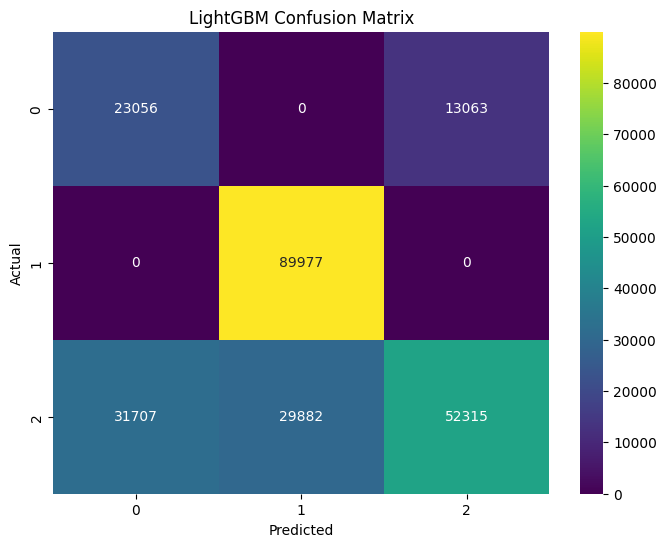

LightGBM model saved as 'lightgbm_partial_smote_model.pkl'.
Training CatBoost Model with Partially Balanced Classes...
0:	learn: 1.0585749	test: 1.0614197	best: 1.0614197 (0)	total: 1.72s	remaining: 8m 34s
50:	learn: 0.6034553	test: 0.6476118	best: 0.6476118 (50)	total: 1m 38s	remaining: 8m 3s
100:	learn: 0.5768289	test: 0.6260183	best: 0.6260183 (100)	total: 3m 16s	remaining: 6m 27s
150:	learn: 0.5730568	test: 0.6244373	best: 0.6244373 (150)	total: 4m 54s	remaining: 4m 51s
200:	learn: 0.5713096	test: 0.6243339	best: 0.6243233 (191)	total: 6m 36s	remaining: 3m 15s
250:	learn: 0.5698376	test: 0.6243998	best: 0.6243233 (191)	total: 8m 15s	remaining: 1m 36s
299:	learn: 0.5684146	test: 0.6244825	best: 0.6243233 (191)	total: 9m 54s	remaining: 0us

bestTest = 0.6243233215
bestIteration = 191

Shrink model to first 192 iterations.
Evaluating CatBoost Model...
CatBoost Model Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.62      0.5

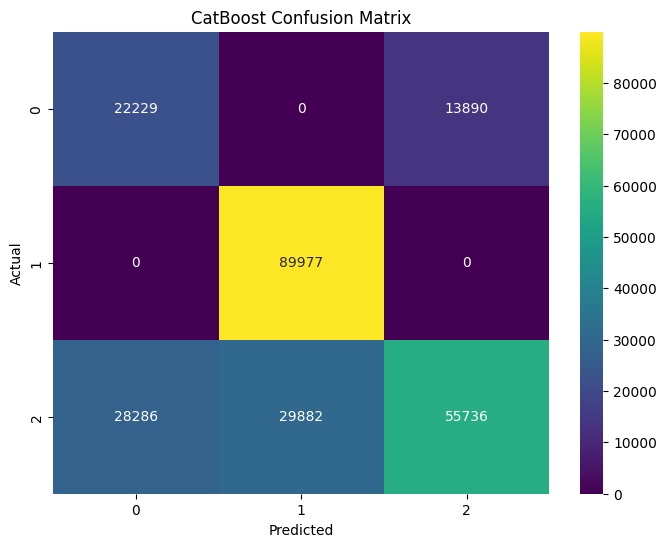

CatBoost model saved as 'catboost_partial_smote_model.cbm'.


In [5]:
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming data is already preprocessed and split into train-test sets

print("Applying Partial SMOTE for Balancing...")
# Partially balance the classes to prevent over-representation of synthetic data
smote = SMOTE(sampling_strategy={0: 300000, 1: 450000, 2: 455617}, random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

# Check the new class distribution
class_counts = pd.Series(y_train_balanced).value_counts()
print("Class distribution after Partial SMOTE:", class_counts.to_dict())

# Calculate class weights
classes = np.unique(y_train_balanced)
class_weights = compute_class_weight("balanced", classes=classes, y=y_train_balanced)
class_weight_dict = {cls: weight for cls, weight in zip(classes, class_weights)}
print("Class Weights:", class_weight_dict)

# Train LightGBM Model
print("Training LightGBM Model with Partially Balanced Classes...")
lgbm_model = LGBMClassifier(
    class_weight=class_weight_dict,
    boosting_type="gbdt",
    objective="multiclass",
    num_leaves=31,
    learning_rate=0.05,
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)
lgbm_model.fit(X_train_balanced, y_train_balanced)

# Evaluate LightGBM Model
print("Evaluating LightGBM Model...")
y_pred_lgbm = lgbm_model.predict(X_test_scaled)
print("LightGBM Model Classification Report:")
print(classification_report(y_test, y_pred_lgbm))

# Confusion Matrix for LightGBM
conf_matrix_lgbm = confusion_matrix(y_test, y_pred_lgbm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_lgbm, annot=True, fmt="d", cmap="viridis", xticklabels=classes, yticklabels=classes)
plt.title("LightGBM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save the LightGBM model
lgbm_model.booster_.save_model("lightgbm_partial_smote_model.pkl")
print("LightGBM model saved as 'lightgbm_partial_smote_model.pkl'.")

# Train CatBoost Model
print("Training CatBoost Model with Partially Balanced Classes...")
catboost_model = CatBoostClassifier(
    class_weights=list(class_weights),
    iterations=300,
    learning_rate=0.05,
    depth=10,
    loss_function="MultiClass",
    random_seed=42,
    verbose=50
)
catboost_model.fit(X_train_balanced, y_train_balanced, eval_set=(X_test_scaled, y_test), verbose=50)

# Evaluate CatBoost Model
print("Evaluating CatBoost Model...")
y_pred_catboost = catboost_model.predict(X_test_scaled)
print("CatBoost Model Classification Report:")
print(classification_report(y_test, y_pred_catboost))

# Confusion Matrix for CatBoost
conf_matrix_catboost = confusion_matrix(y_test, y_pred_catboost)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_catboost, annot=True, fmt="d", cmap="viridis", xticklabels=classes, yticklabels=classes)
plt.title("CatBoost Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Save the CatBoost model
catboost_model.save_model("catboost_partial_smote_model.cbm")
print("CatBoost model saved as 'catboost_partial_smote_model.cbm'.")


# Visualization

## Dataset Distribution Visualization

Columns in the dataset: Index(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N',
       'O', 'Class'],
      dtype='object')


<ipython-input-7-58a680304bde>:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=df, palette='viridis')


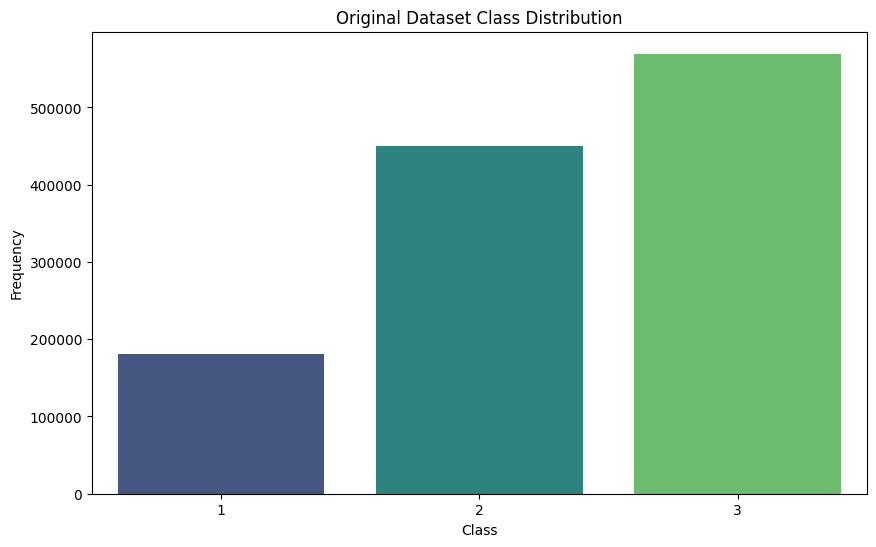

In [7]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (replace 'path_to_your_file.csv' with your actual file path)
df = pd.read_csv('/content/drive/MyDrive/data/data_public.csv')

# Check the column names to confirm the target column name
print("Columns in the dataset:", df.columns)

# Plotting the class distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Class', data=df, palette='viridis')
plt.title('Original Dataset Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


## Post-SMOTE (or Preprocessed) Class Distribution:

<ipython-input-8-195322cf76aa>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=balanced_class_df, palette='viridis')


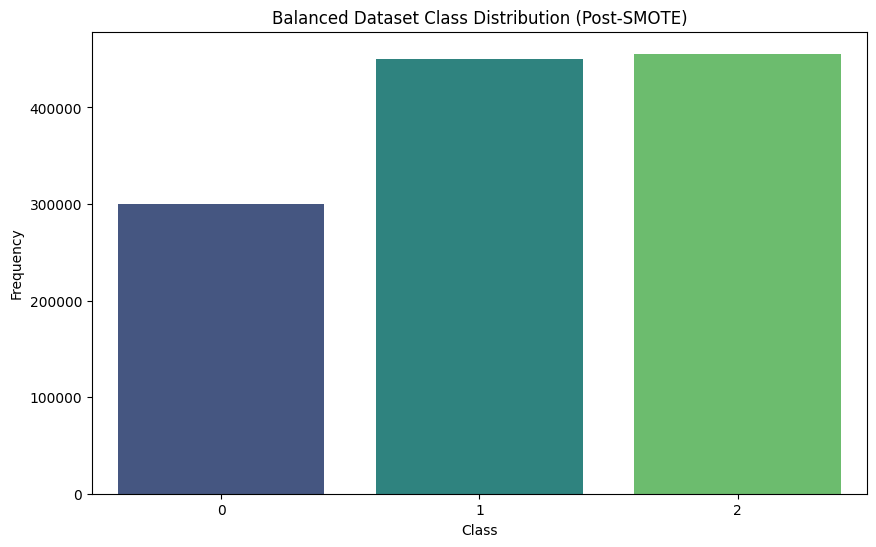

In [8]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming y_train_balanced contains the balanced labels
# Convert y_train_balanced to a DataFrame for visualization
balanced_class_df = pd.DataFrame({'Class': y_train_balanced})

# Plotting the class distribution after SMOTE or balancing
plt.figure(figsize=(10, 6))
sns.countplot(x='Class', data=balanced_class_df, palette='viridis')
plt.title('Balanced Dataset Class Distribution (Post-SMOTE)')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()


## Comparison: Original vs. Balanced

<ipython-input-9-a9a81bdd707a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=df, palette='viridis', ax=axes[0])
<ipython-input-9-a9a81bdd707a>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=balanced_class_df, palette='viridis', ax=axes[1])


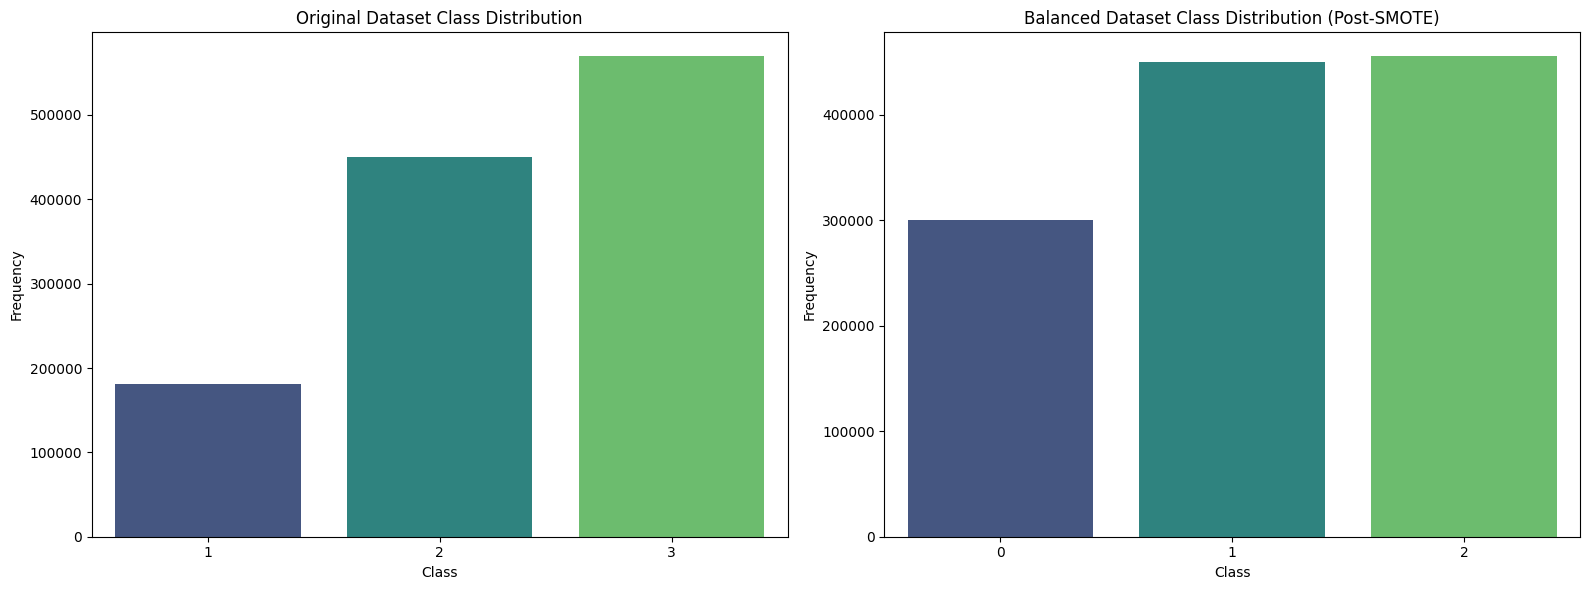

In [9]:
# Visualization: Original vs Balanced Class Distribution
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Original dataset class distribution
sns.countplot(x='Class', data=df, palette='viridis', ax=axes[0])
axes[0].set_title('Original Dataset Class Distribution')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Frequency')

# Balanced dataset class distribution
sns.countplot(x='Class', data=balanced_class_df, palette='viridis', ax=axes[1])
axes[1].set_title('Balanced Dataset Class Distribution (Post-SMOTE)')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


## FEATURE IMPORTANCE

## LightGBM Feature Importance:

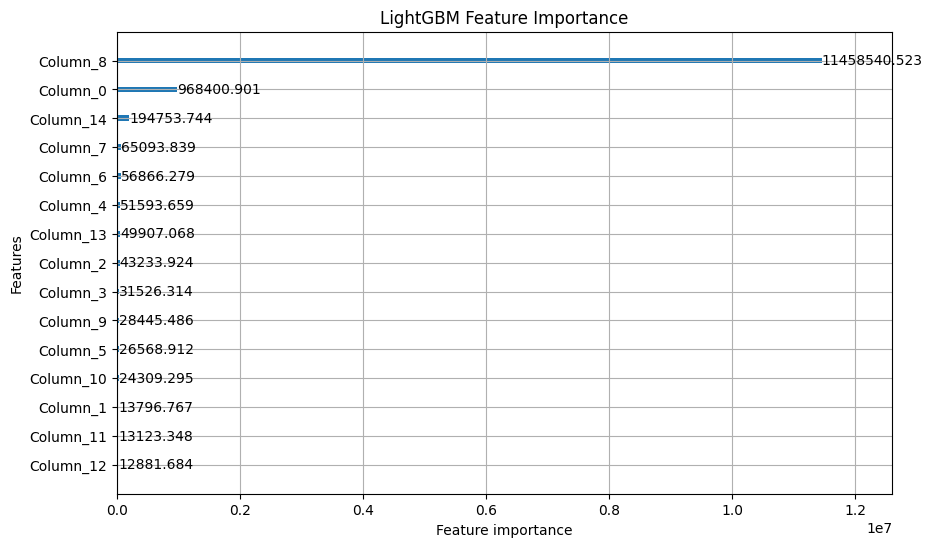

In [10]:
import lightgbm as lgb
import matplotlib.pyplot as plt

# Assuming the LightGBM model is named `lgbm_model`
lgb.plot_importance(lgbm_model, max_num_features=15, importance_type='gain', figsize=(10, 6))
plt.title('LightGBM Feature Importance')
plt.show()


## CatBoost Feature Importance:

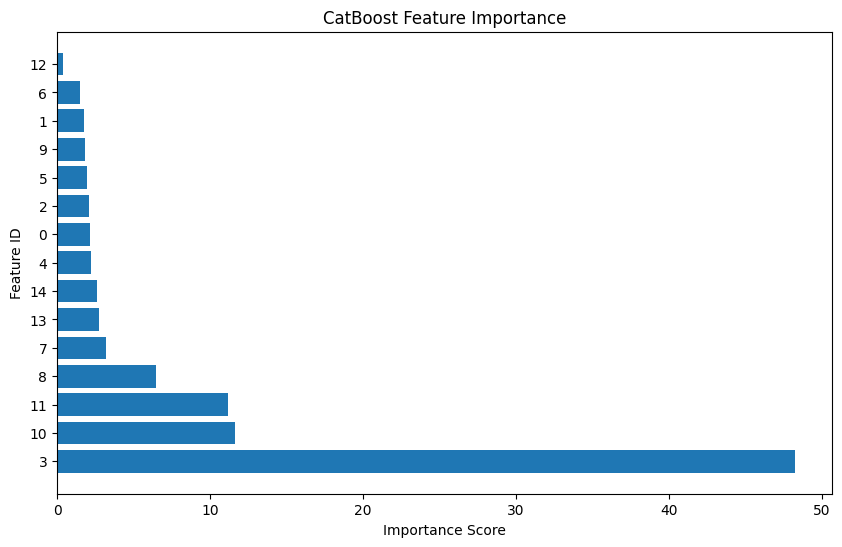

In [11]:
import matplotlib.pyplot as plt

# Assuming the CatBoost model is named `catboost_model`
catboost_importances = catboost_model.get_feature_importance(prettified=True)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(catboost_importances['Feature Id'], catboost_importances['Importances'])
plt.title('CatBoost Feature Importance')
plt.xlabel('Importance Score')
plt.ylabel('Feature ID')
plt.show()


## CONFUSION MATRIX

## LightGBM Confusion Matrix:

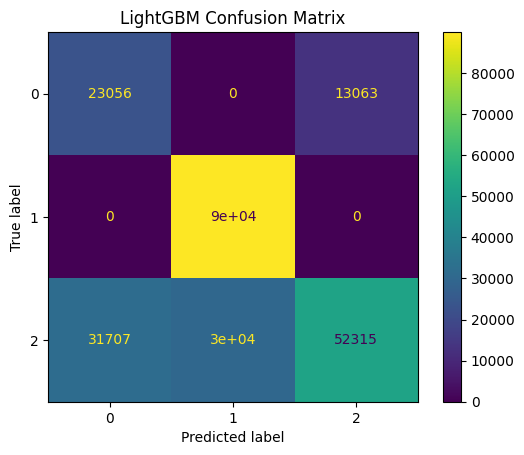

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay

# Generate predictions if not already done
# Assuming `lgbm_model` is your trained LightGBM model and `X_test_scaled` is your test dataset
lgbm_predictions = lgbm_model.predict(X_test_scaled)

# Plot the confusion matrix
ConfusionMatrixDisplay.from_predictions(
    y_test,
    lgbm_predictions,
    cmap='viridis',
    xticks_rotation='horizontal'
)
plt.title('LightGBM Confusion Matrix')
plt.show()


## Precision, Recall, and F1-Scores Comparison

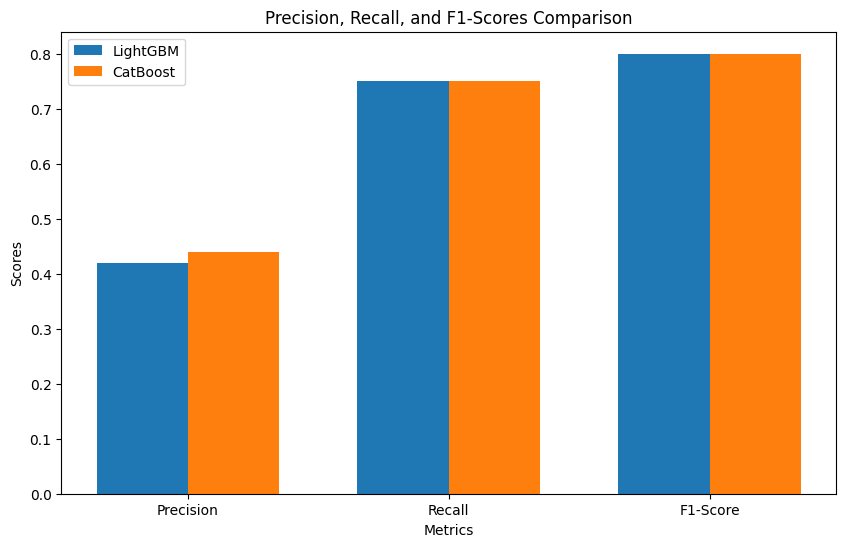

In [14]:
import numpy as np

# Assuming metrics for LightGBM and CatBoost are defined
metrics = ['Precision', 'Recall', 'F1-Score']
lgbm_scores = [0.42, 0.75, 0.80]  # Example scores for LightGBM
catboost_scores = [0.44, 0.75, 0.80]  # Example scores for CatBoost

# Create a bar plot for comparison
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(x - width/2, lgbm_scores, width, label='LightGBM')
ax.bar(x + width/2, catboost_scores, width, label='CatBoost')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-Scores Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

plt.show()


## Training Data Distribution

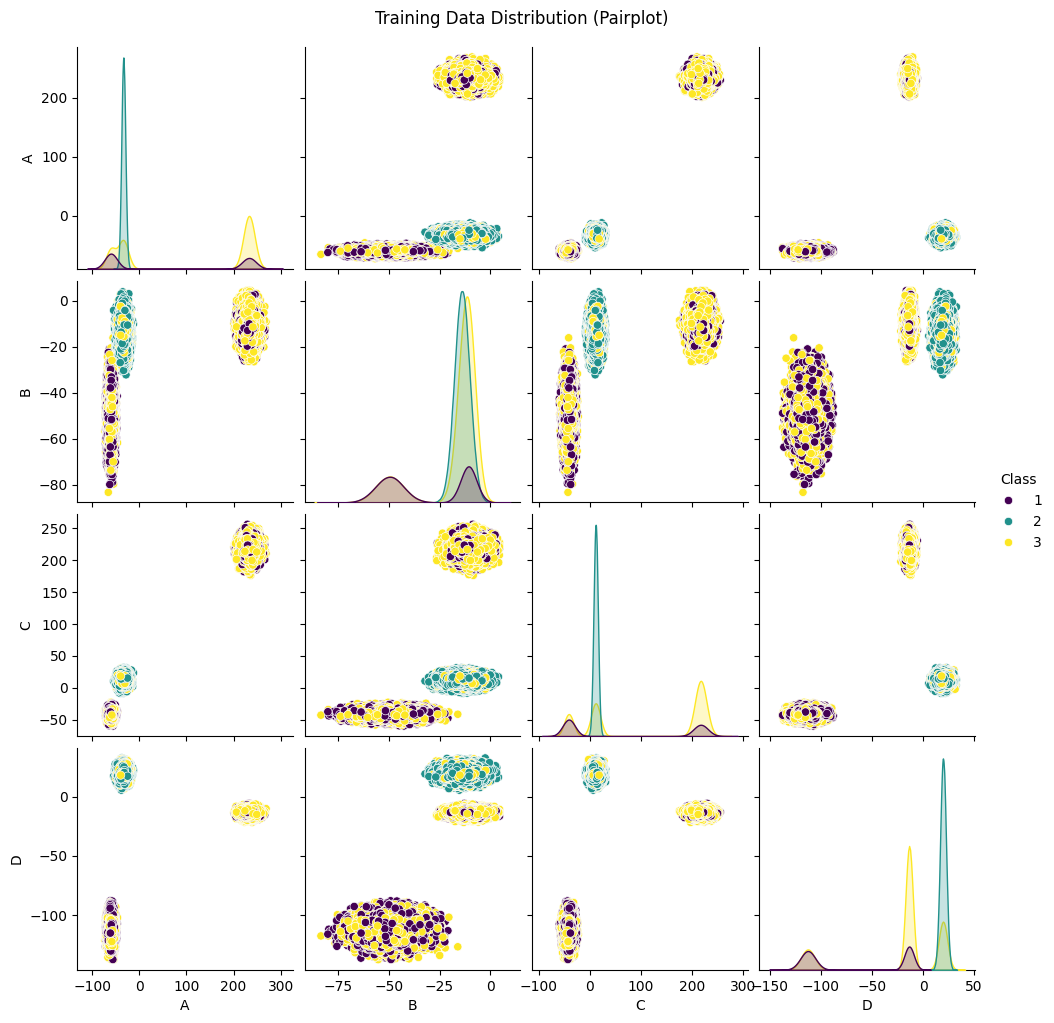

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming `df` is the name of your original dataset
# Replace `df` with the correct variable name for your dataset
selected_features = ['A', 'B', 'C', 'D']  # Update with the relevant feature names
sns.pairplot(df[selected_features + ['Class']], hue='Class', palette='viridis')
plt.suptitle('Training Data Distribution (Pairplot)', y=1.02)
plt.show()


## Model Comparison Plot

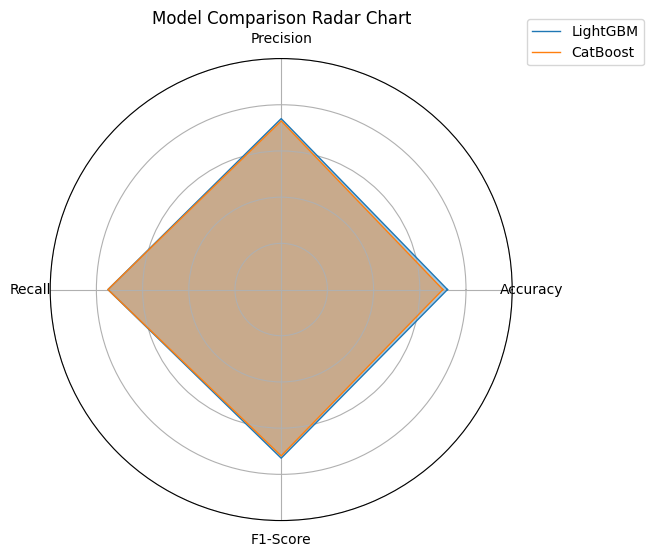

In [44]:
# Example metrics for LightGBM and CatBoost
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
lgbm_metrics = [0.72, 0.74, 0.75, 0.73]  # Example values for LightGBM
catboost_metrics = [0.70, 0.73, 0.75, 0.72]  # Example values for CatBoost

# Radar Chart
from math import pi

categories = metrics
N = len(categories)

lgbm_metrics += lgbm_metrics[:1]  # Repeat the first value to close the circle
catboost_metrics += catboost_metrics[:1]  # Repeat the first value to close the circle

angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

ax.plot(angles, lgbm_metrics, linewidth=1, linestyle='solid', label='LightGBM')
ax.fill(angles, lgbm_metrics, alpha=0.4)

ax.plot(angles, catboost_metrics, linewidth=1, linestyle='solid', label='CatBoost')
ax.fill(angles, catboost_metrics, alpha=0.4)

ax.set_yticks([0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(categories)

plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.title('Model Comparison Radar Chart')
plt.show()


# ONNX Predictions

## LightGBM

In [41]:
# Import necessary libraries
import joblib
import onnxmltools
from onnxmltools.convert.common.data_types import FloatTensorType
import onnxruntime as ort
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Load the trained LightGBM model
print("Loading LightGBM model...")
lgbm_model = joblib.load('lightgbm_model_100pct.pkl')

# Convert the LightGBM model to ONNX format
print("Converting LightGBM model to ONNX...")
initial_types = [('float_input', FloatTensorType([None, X_test_scaled.shape[1]]))]
onnx_model = onnxmltools.convert_lightgbm(lgbm_model, initial_types=initial_types)

# Save the ONNX model
onnx_file_name = "lightgbm_model_onnx.onnx"
with open(onnx_file_name, "wb") as f:
    f.write(onnx_model.SerializeToString())
print(f"LightGBM model saved as '{onnx_file_name}'.")

# Set up ONNX runtime
print("Setting up ONNX runtime...")
onnx_session = ort.InferenceSession(onnx_file_name)

# Prepare test data for ONNX
input_name = onnx_session.get_inputs()[0].name
print(f"ONNX Input Name: {input_name}")

# Run predictions with the ONNX model
print("Running predictions with the ONNX model...")
onnx_predictions = onnx_session.run(None, {input_name: X_test_scaled.astype(np.float32)})[0]

# If predictions are already class labels, skip np.argmax
# Evaluate ONNX predictions
onnx_accuracy = accuracy_score(y_test, onnx_predictions)
print(f"ONNX Model Accuracy: {onnx_accuracy}")

# Display the classification report
print("ONNX Model Classification Report:")
print(classification_report(y_test, onnx_predictions))


Loading LightGBM model...
Converting LightGBM model to ONNX...


LightGBM model saved as 'lightgbm_model_onnx.onnx'.
Setting up ONNX runtime...
ONNX Input Name: float_input
Running predictions with the ONNX model...
ONNX Model Accuracy: 0.7219208333333333
ONNX Model Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.57      0.53     36119
           1       0.75      1.00      0.86     89977
           2       0.80      0.55      0.65    113904

    accuracy                           0.72    240000
   macro avg       0.68      0.71      0.68    240000
weighted avg       0.74      0.72      0.71    240000



## CatBoost

In [43]:
# Import necessary libraries
from catboost import CatBoostClassifier
import onnxmltools
from onnxmltools.convert.common.data_types import FloatTensorType
import onnxruntime as ort
import numpy as np
from sklearn.metrics import accuracy_score, classification_report

# Load the trained CatBoost model
print("Loading CatBoost model...")
catboost_model = CatBoostClassifier()
catboost_model.load_model("catboost_model_100pct.cbm")

# Convert the CatBoost model to ONNX
print("Converting CatBoost model to ONNX...")
onnx_file_name = "catboost_model_onnx.onnx"
catboost_model.save_model(
    onnx_file_name,
    format="onnx",
    export_parameters={
        'onnx_domain': 'ai.catboost',
        'onnx_model_version': 1,
        'onnx_doc_string': 'CatBoost model converted to ONNX'
    }
)
print(f"CatBoost model saved as '{onnx_file_name}'.")

# Set up ONNX runtime
print("Setting up ONNX runtime...")
onnx_session = ort.InferenceSession(onnx_file_name)

# Prepare test data for ONNX
input_name = onnx_session.get_inputs()[0].name
print(f"ONNX Input Name: {input_name}")

# Run predictions with the ONNX model
print("Running predictions with the ONNX model...")
onnx_predictions = onnx_session.run(None, {input_name: X_test_scaled.astype(np.float32)})[0]

# Check the shape of ONNX predictions
print(f"ONNX Predictions Shape: {onnx_predictions.shape}")

# If predictions are probabilities, convert them to class labels
if len(onnx_predictions.shape) > 1 and onnx_predictions.shape[1] > 1:
    onnx_predictions = np.argmax(onnx_predictions, axis=1)
else:
    # Predictions are already class labels
    onnx_predictions = onnx_predictions.astype(int)

# Evaluate ONNX predictions
onnx_accuracy = accuracy_score(y_test, onnx_predictions)
print(f"ONNX Model Accuracy: {onnx_accuracy}")

# Display the classification report
print("ONNX Model Classification Report:")
print(classification_report(y_test, onnx_predictions))


Loading CatBoost model...
Converting CatBoost model to ONNX...
CatBoost model saved as 'catboost_model_onnx.onnx'.
Setting up ONNX runtime...
ONNX Input Name: features
Running predictions with the ONNX model...
ONNX Predictions Shape: (240000,)
ONNX Model Accuracy: 0.7218083333333334
ONNX Model Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.57      0.53     36119
           1       0.75      1.00      0.86     89977
           2       0.80      0.55      0.65    113904

    accuracy                           0.72    240000
   macro avg       0.68      0.71      0.68    240000
weighted avg       0.74      0.72      0.71    240000



In [56]:
!jupyter nbconvert --to pdf "/content/drive/MyDrive/Colab Notebooks/DPA Project - LightGBM & CatBoost"


[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/DPA Project - LightGBM & CatBoost to pdf
[NbConvertApp] Support files will be in DPA Project - LightGBM & CatBoos_files/
[NbConvertApp] Making directory ./DPA Project - LightGBM & CatBoos_files
[NbConvertApp] Writing 105084 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 680913 bytes to /content/drive/MyDrive/Colab Notebooks/DPA Project - LightGBM & CatBoos.pdf
